<a href="https://colab.research.google.com/github/feniltailor22/Machine_Learning-and-Deep_Learning/blob/main/Semantic_Segmentation_of_Nuclei_using_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import tensorflow as tf

In [16]:
from tqdm import tqdm 
import random
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [45]:
img= cv2.imread('/content/drive/MyDrive/Semantic Segmentation using UNet/UNet Architecture.png')

Text(0.5, 1.0, 'UNet Architecture')

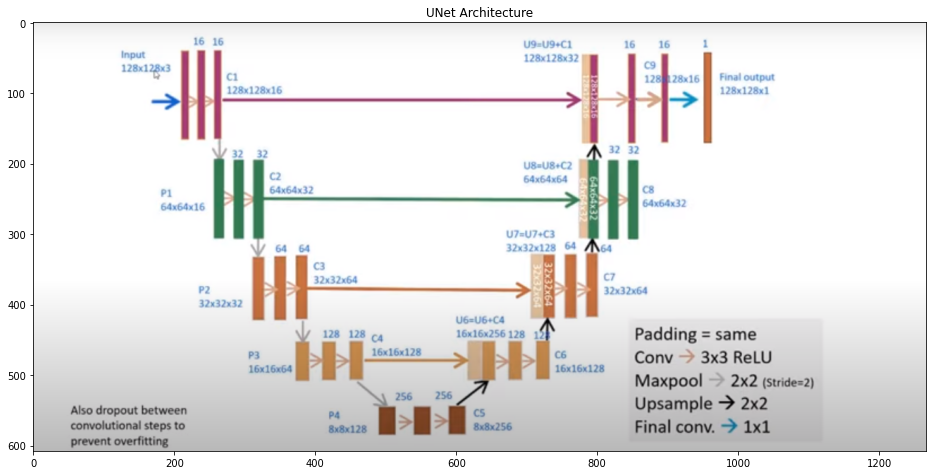

In [46]:
plt.figure(figsize = (16,20))
plt.imshow(img)
plt.title('UNet Architecture')

In [4]:
img_width= 128
img_height= 128
img_channels= 3

In [6]:
TRAIN_PATH = '/content/drive/MyDrive/Semantic Segmentation using UNet/Train/'
TEST_PATH = '/content/drive/MyDrive/Semantic Segmentation using UNet/Test/'

In [7]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [8]:
X_train = np.zeros((len(train_ids), img_height, img_width, img_channels), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), img_height, img_width, 1), dtype=np.bool)

In [10]:
#Resizing training images and masks

In [11]:
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:img_channels]  
    img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((img_height, img_width, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (img_height, img_width), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask   

100%|██████████| 67/67 [10:31<00:00,  9.43s/it]


In [12]:
# test images
X_test = np.zeros((len(test_ids), img_height, img_width, img_channels), dtype=np.uint8)
sizes_test = []

In [13]:
#Resizing test images

In [14]:
 for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:img_channels]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
    X_test[n] = img

100%|██████████| 35/35 [00:15<00:00,  2.27it/s]


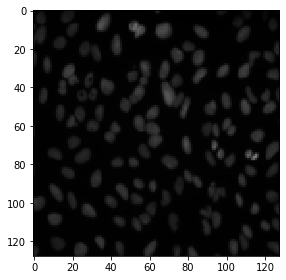

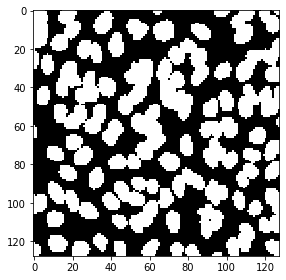

In [17]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [18]:
#Building the model

In [19]:
inputs= tf.keras.layers.Input(shape=(img_width, img_height, img_channels)) #Input Layer
std_inputs= tf.keras.layers.Lambda(lambda x: x/255)(inputs) #standardizing the input image

In [20]:
#Contraction Path (Encoder)

In [21]:
c1= tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(std_inputs) #Conv-1.1
c1= tf.keras.layers.Dropout(rate=0.1)(c1) #Dropout
c1= tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1) #Conv-1.2
p1= tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c1) #MaxPooling

In [22]:
c2= tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1) #Conv-2.1
c2= tf.keras.layers.Dropout(rate=0.1)(c2) #Dropout
c2= tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2) #Conv-2.2
p2= tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c2) #MaxPooling

In [23]:
c3= tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2) #Conv-3.1
c3= tf.keras.layers.Dropout(rate=0.2)(c3) #Dropout
c3= tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3) #Conv-3.2
p3= tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c3) #MaxPooling

In [24]:
c4= tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3) #Conv-4.1
c4= tf.keras.layers.Dropout(rate=0.2)(c4) #Dropout
c4= tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4) #Conv-4.2
p4= tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c4) #MaxPooling

In [25]:
c5= tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4) #Conv-5.1
c5= tf.keras.layers.Dropout(rate=0.3)(c5) #Dropout
c5= tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5) #Conv-5.2
p5= tf.keras.layers.MaxPooling2D(pool_size=(2,2))(c5) #MaxPooling

In [26]:
#Expansive path (Decoder)

In [27]:
u6 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(2, 2), strides=(2, 2), padding='same')(c5) #ConvT-6.1
u6 = tf.keras.layers.concatenate([u6, c4]) #u6+c4
c6 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6) #Conv-6.2
c6 = tf.keras.layers.Dropout(0.2)(c6) #Dropout
c6 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6) #Conv-6.3

In [28]:
u7 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=(2, 2), padding='same')(c6) #ConvT-7.1
u7 = tf.keras.layers.concatenate([u7, c3]) #u7+c3
c7 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7) #Conv-7.2
c7 = tf.keras.layers.Dropout(0.2)(c7) #Dropout
c7 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7) #Conv-7.3

In [29]:
u8 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=(2, 2), padding='same')(c7) #ConvT-8.1
u8 = tf.keras.layers.concatenate([u8, c2]) #u8+c2
c8 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8) #Conv-8.2
c8 = tf.keras.layers.Dropout(0.1)(c8) #Dropout
c8 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8) #Conv-8.3

In [30]:
u9 = tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=(2, 2), strides=(2, 2), padding='same')(c8) #ConvT-9.1
u9 = tf.keras.layers.concatenate([u9, c1]) #u9+c1
c9 = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9) #Conv-9.2
c9 = tf.keras.layers.Dropout(0.1)(c9) #Dropout
c9 = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9) #Conv-9.3

In [31]:
outputs = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(c9) #Output Layer

In [32]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [33]:
#Modelcheckpoint

In [34]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

In [35]:
results= model.fit(
    x=X_train,
    y=Y_train,
    batch_size=16,
    epochs=25,
    verbose=True,
    callbacks=callbacks,
    validation_split=0.1
)

Epoch 1/25
4/4 [==============================] - 36s 842ms/step - loss: 0.6573 - accuracy: 0.7759 - val_loss: 0.6365 - val_accuracy: 0.7791
Epoch 2/25
4/4 [==============================] - 0s 108ms/step - loss: 0.7546 - accuracy: 0.8072 - val_loss: 0.6244 - val_accuracy: 0.7791
Epoch 3/25
4/4 [==============================] - 0s 107ms/step - loss: 0.6121 - accuracy: 0.8072 - val_loss: 0.6312 - val_accuracy: 0.7791
Epoch 4/25
4/4 [==============================] - 0s 105ms/step - loss: 0.6170 - accuracy: 0.8072 - val_loss: 0.6190 - val_accuracy: 0.7791
Epoch 5/25
4/4 [==============================] - 0s 108ms/step - loss: 0.5997 - accuracy: 0.8072 - val_loss: 0.6001 - val_accuracy: 0.7791
Epoch 6/25
4/4 [==============================] - 0s 108ms/step - loss: 0.5789 - accuracy: 0.8072 - val_loss: 0.5859 - val_accuracy: 0.7791
Epoch 7/25
4/4 [==============================] - 0s 108ms/step - loss: 0.5557 - accuracy: 0.8072 - val_loss: 0.5627 - val_accuracy: 0.7791
Epoch 8/25
4/4 [===

In [36]:
idx = random.randint(0, len(X_train))

In [37]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

2/2 [==============================] - 0s 441ms/step


In [38]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [39]:
# Perform a sanity check on some random training samples

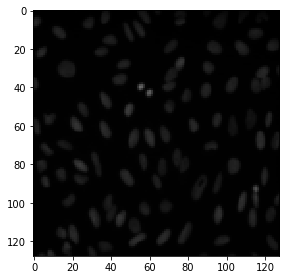

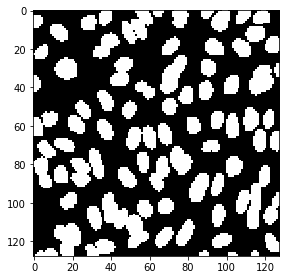

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


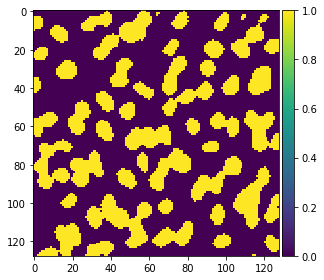

In [40]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [41]:
# Perform a sanity check on some random validation samples

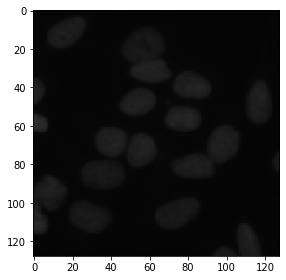

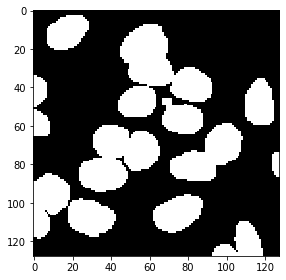

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


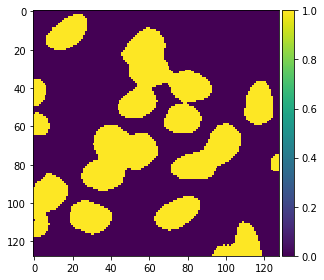

In [42]:
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()